<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Make-subimages-from-full-maps" data-toc-modified-id="Make-subimages-from-full-maps-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Make subimages from full maps</a></span></li><li><span><a href="#Load-subimages-and-split-into-features-and-labels" data-toc-modified-id="Load-subimages-and-split-into-features-and-labels-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load subimages and split into features and labels</a></span></li><li><span><a href="#Preprocess--subimages-pre-training" data-toc-modified-id="Preprocess--subimages-pre-training-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Preprocess  subimages pre training</a></span></li><li><span><a href="#Make-dataset,-model-and-train" data-toc-modified-id="Make-dataset,-model-and-train-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Make dataset, model and train</a></span></li><li><span><a href="#Evaluate-data-on-experimental-dataset" data-toc-modified-id="Evaluate-data-on-experimental-dataset-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Evaluate data on experimental dataset</a></span></li></ul></div>

In [15]:
import sys, os,imp, glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

import QFlow as QF
imp.reload(QF)

<module 'QFlow' from '/Users/jz/pythonprojects/data_release_repo/QFlow/__init__.py'>

# Make subimages from full maps

In [2]:
raw_dat_file = os.path.join('..','QFlow-2.0','Data','bn_noCP_1.5m_0.5std.hdf5')

cropper = QF.Crop_Data.DataCropper(excl_range=20)

cropped_data = cropper.crop_full_dataset(
    raw_dat_file, save_data=True, return_data=False)

15990


# Load subimages and split into features and labels
Note that the features at this stage are fully unprocessed.

In [3]:
subs_file = os.path.join('..','QFlow-2.0', 'Data','bn_noCP_1.5m_0.5std.npz')

# Specify here what type of label we want. Options are 'state' or 'data_quality'.
# This has to match the type of model created by Prepare_ML.create_model()
t_data, t_labels, e_data, e_labels = QF.Process_Data.get_data(
    subs_file, label_key='state')

Total number of samples : 15990
Training data info: (14391, 30, 30, 1)
Evaluation data info: (1599, 30, 30, 1)


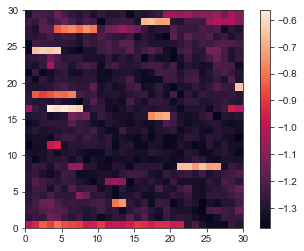

In [4]:
# plot subimage to make sure everything looks ok
plt.pcolor(t_data[0,:,:,0])
ax = plt.gca()
ax.set_aspect('equal')
plt.colorbar()
plt.show()

# Preprocess  subimages pre training

In [5]:
# Don't autoflip because our simulated data has fixed orientation.
# Don't apply denoising because it doesn't help.
prepper = QF.Process_Data.Preprocessor(
    autoflip=False, denoising=[], clip_val=None, thresh_val=None)

# preprocess training and eval data
proc_t_data = prepper.proc_subimage_set(t_data)
proc_e_data = prepper.proc_subimage_set(e_data)

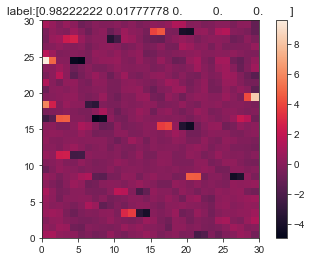

In [6]:
# plot processed subimage to make sure everything looks ok
test_idx = 0
plt.pcolor(proc_t_data[test_idx,:,:,0])
ax = plt.gca()
ax.set_aspect('equal')
plt.title('label:'+str(t_labels[test_idx]))
plt.colorbar()
plt.show()

# Make dataset, model and train 

In [7]:
train_ds = QF.Prepare_ML.input_fn(proc_t_data, t_labels)
eval_ds = QF.Prepare_ML.input_fn(proc_e_data, e_labels)

In [8]:
# create and train model for either state estimation or quality control.
# valid model_types are: 'state_estimator' or 'quality_control'
# for 'state_estimator', valid model_opts are 'best_noise_opt' or 'noiseless_opt'
# for 'quality_control', valid model_opts are 'uniform_noise_dist_opt'
model = QF.Prepare_ML.create_model(
    model_type='state_estimator', model_opt='noiseless_opt')

history = model.fit(train_ds, validation_data=eval_ds, epochs=10)

Epoch 1/10
137/137 [==============================] - 5s 29ms/step - loss: 1.5087 - accuracy: 0.2840 - val_loss: 0.9421 - val_accuracy: 0.6188
Epoch 2/10
137/137 [==============================] - 3s 25ms/step - loss: 0.9572 - accuracy: 0.6102 - val_loss: 0.7621 - val_accuracy: 0.7282
Epoch 3/10
137/137 [==============================] - 3s 25ms/step - loss: 0.8157 - accuracy: 0.6864 - val_loss: 0.7436 - val_accuracy: 0.7271
Epoch 4/10
137/137 [==============================] - 3s 25ms/step - loss: 0.7406 - accuracy: 0.7411 - val_loss: 0.6799 - val_accuracy: 0.7823
Epoch 5/10
137/137 [==============================] - 3s 24ms/step - loss: 0.7020 - accuracy: 0.7631 - val_loss: 0.6637 - val_accuracy: 0.7901
Epoch 6/10
137/137 [==============================] - 3s 25ms/step - loss: 0.6836 - accuracy: 0.7750 - val_loss: 0.6308 - val_accuracy: 0.8044
Epoch 7/10
137/137 [==============================] - 3s 25ms/step - loss: 0.6583 - accuracy: 0.7906 - val_loss: 0.6468 - val_accuracy: 0.7923

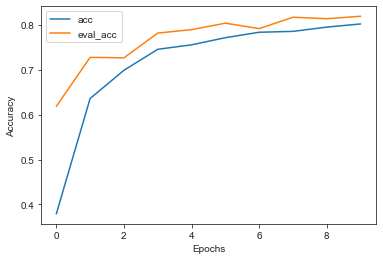

In [9]:
# check that training converged nicely
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='eval_acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate data on experimental dataset

In [32]:
# load data
data_files = glob.glob(os.path.join('..','exp_data_release','*','*.npy'))

# extract only what we need from the data.
# note that there is no noise_class label for experimental data
exp_data = []; exp_labels = []
for f in data_files:
    d = np.load(f, allow_pickle=True).item()
    exp_data.append(d['sensor'])
    exp_labels.append(d['label'])

# convert only labels to list because exp_data contains different shaped data.
exp_labels = np.array(exp_labels)

# preprocess
# Autoflip because sensor gradient sign is unknown. 
# Don't denoise because it doesn't help.
exp_prepper = QF.Process_Data.Preprocessor(
    autoflip=True, denoising=[], clip_val=None, thresh_val=None)

proc_exp_data = exp_prepper.proc_subimage_set(exp_data)

In [34]:
# evaluate model on process data
history = model.evaluate(proc_exp_data, exp_labels)

20/20 [==============================] - 0s 4ms/step - loss: 0.5004 - accuracy: 0.8183
